# Identificación de la respuesta al impulso

Se identifica un modelo ARMAX entrando con
- impulso
- escalón y luego derivando (restando muestras sucesivas) 

Se observa que el segundo método brinda una mejor predicción de la respuesta al escalón

In [ ]:
import control as ctrl
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as signal

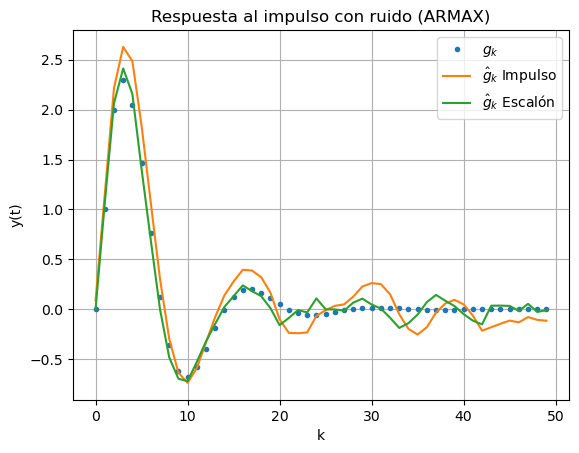

In [ ]:
# Amplitud del impulso
alpha = 2

# Parámetros ARMAX ejemplo
A = [1, -1.5, 0.7]
B = [0, 1, 0.5]
C = [1]

# Entrada impulso
N = 50
u = np.zeros(N)
u[0] = alpha  # impulso en t=0

# Entrada escalón
ue = alpha*np.ones(N)

# Ruido blanco
np.random.seed(0)
e = np.random.normal(0, 0.1, N)

# Filtro de la entrada
y_u = signal.lfilter(B, A, u)
y_ue = signal.lfilter(B, A, ue)

# Filtro del ruido
y_e = signal.lfilter(C, A, e)

# Salida total
y = y_u + y_e
ye = y_ue + y_e

g_hat_e = np.concatenate([[0],np.diff(ye)])/alpha
g_hat = y/alpha
g = y_u/alpha
g_ejemplo0 = g

# Graficar
plt.plot(g,'.', label='$g_k$')
plt.plot(g_hat, label='$\\hat{{g}}_k$ Impulso')
plt.plot(g_hat_e, label='$\\hat{{g}}_k$ Escalón')
plt.xlabel("k")
plt.ylabel("y(t)")
plt.legend()
plt.title("Respuesta al impulso con ruido (ARMAX)")
plt.grid()
plt.show()


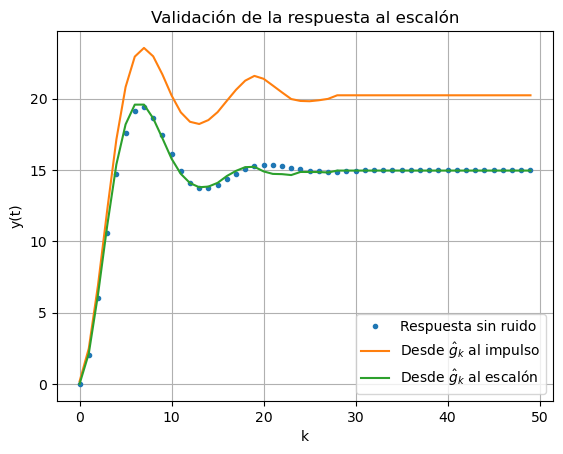

In [65]:
#ye_hat = np.cumsum(g_hat) * alpha
#yee_hat = np.cumsum(g_hat_e) * alpha
N_filtro = 30
ye_hat = signal.lfilter(g_hat[0:N_filtro-1],[1],ue)
yee_hat = signal.lfilter(g_hat_e[0:N_filtro-1],[1],ue)

plt.plot(y_ue,'.',label='Respuesta sin ruido')
plt.plot(ye_hat,label='Desde $\\hat{{g}}_k$ al impulso')
plt.plot(yee_hat,label='Desde $\\hat{{g}}_k$ al escalón')
plt.title("Validación de la respuesta al escalón")
plt.xlabel("k")
plt.ylabel("y(t)")
plt.grid()
plt.legend()


## Ejemplo: sistemas con respuesta al impulso parecidas y respuestas al escalón diferentes

TransferFunction(
array([1.1777]),
array([1.1216, 1.    ]),
outputs=1, inputs=1)

<TransferFunction>: sys[227]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

        s + 0.2066
  -----------------------
  s^2 + 0.9808 s + 0.1994


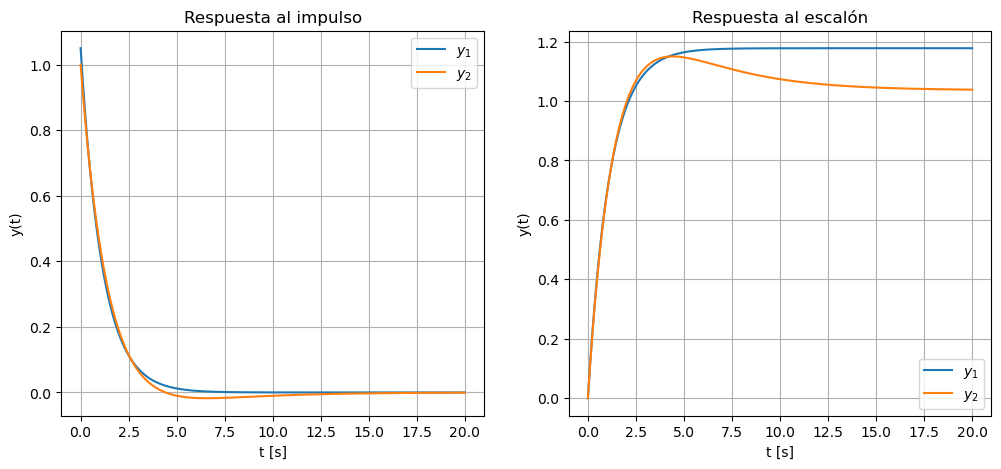

In [77]:
s = ctrl.TransferFunction.s

G1 = 1.1777/(1.1216*s+1)
display(G1)
G2 = (s+0.2066)/((s+0.6931)*(s+0.2877))
print(G2)

t = np.linspace(0,20,1000)
_, y1 = ctrl.impulse_response(G1,T=t)
_, y2 = ctrl.impulse_response(G2,T=t)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t,y1,label='$y_1$')
plt.plot(t,y2,label='$y_2$')
plt.title('Respuesta al impulso')
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('y(t)')
plt.legend()

_, y1 = ctrl.step_response(G1,T=t)
_, y2 = ctrl.step_response(G2,T=t)

plt.subplot(1,2,2)
plt.plot(t,y1,label='$y_1$')
plt.plot(t,y2,label='$y_2$')
plt.title('Respuesta al escalón')
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('y(t)')
plt.legend()

## Ejemplo: sistemas con respuesta al impulso diferentes y respuestas al escalón parecidas

<TransferFunction>: sys[261]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

          1.946
  ---------------------
  s^2 + 2.66 s + 0.8215
<TransferFunction>: sys[265]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     0.8
  ----------
  s + 0.3147


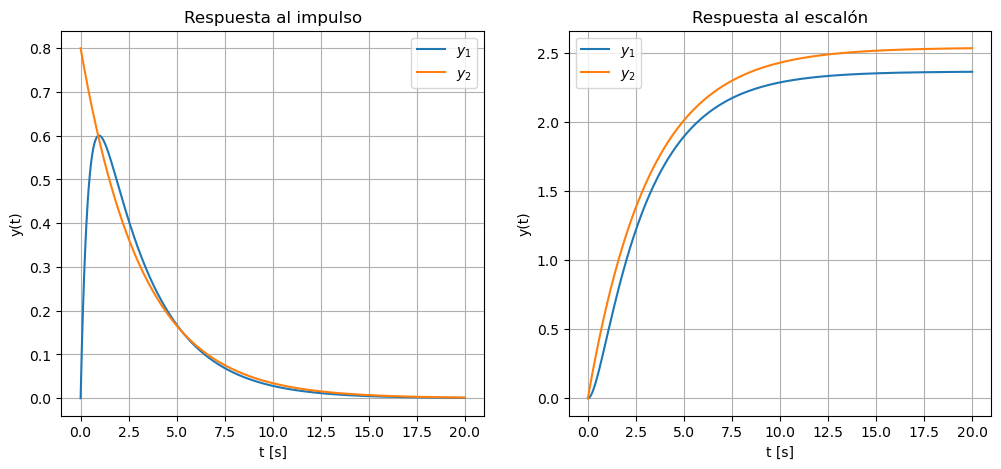

In [79]:
s = ctrl.TransferFunction.s

G1 = 1.9459/((s+2.303)*(s+0.3567))
print(G1)
G2 = (0.8)/(s+0.3147)
print(G2)

t = np.linspace(0,20,1000)
_, y1 = ctrl.impulse_response(G1,T=t)
_, y2 = ctrl.impulse_response(G2,T=t)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t,y1,label='$y_1$')
plt.plot(t,y2,label='$y_2$')
plt.title('Respuesta al impulso')
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('y(t)')
plt.legend()

_, y1 = ctrl.step_response(G1,T=t)
_, y2 = ctrl.step_response(G2,T=t)

plt.subplot(1,2,2)
plt.plot(t,y1,label='$y_1$')
plt.plot(t,y2,label='$y_2$')
plt.title('Respuesta al escalón')
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('y(t)')
plt.legend()

## Identificación por respuesta al pulso

[ 0.          0.00019893  0.00079143 ... -0.00098539 -0.0009778
 -0.00096994]


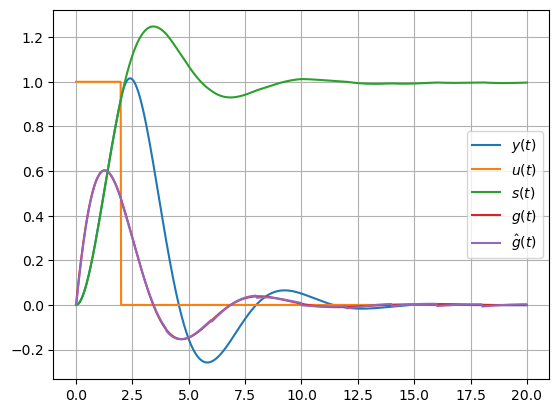

In [153]:
u = np.zeros(1001)
Np = 100
u[0:Np] = 1

t = np.linspace(0,20,1001)
s = ctrl.TransferFunction.s
G1 = 1/(s**2 + 0.8*s + 1)
_,yp = ctrl.forced_response(G1,T=t,U=u)
_, g = ctrl.impulse_response(G1,T=t)

# Reconstruyo la respuesta al escalón a partir de las mediciones
st = np.zeros_like(yp)
for k in range(len(yp)):
    if k < Np:
        # s[k] = Np * yp[k] (porque s[k-Np] = 0 cuando k < Np)
        st[k] = yp[k]
    else:
        # s[k] = s[k-Np] + Np * yp[k]
        st[k] = st[k - Np] + yp[k]

print(yp)
#st[0:Np] = yp[0:Np]
#for i in range(Np,len(yp)):
#    st[i] = yp[i]+st[i-Np]

#g = np.concatenate([[0], np.diff(st)])*Np
dt = t[1] - t[0]
g_hat = np.diff(st, prepend=0) / dt   # o np.gradient(st, dt)


plt.plot(t,yp,label='$y(t)$')
plt.plot(t,u,label='$u(t)$')
plt.plot(t,st,label='$s(t)$')
plt.plot(t,g,label='$g(t)$')
plt.plot(t,g_hat,label='$\\hat{{g}}(t)$')
plt.legend()
plt.grid()
plt.show()



## Identificación por correlación

Media de urb=0.00916
Varianza de urb=0.9999160944


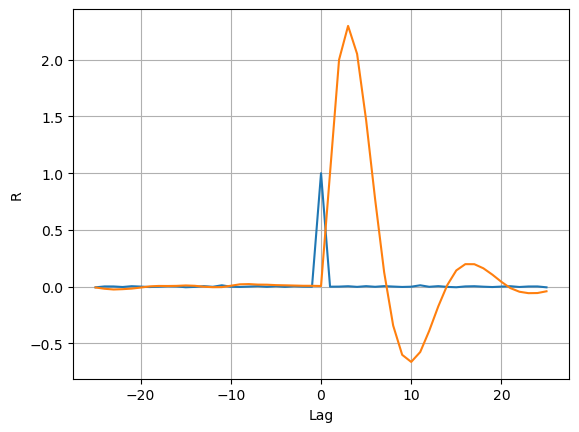

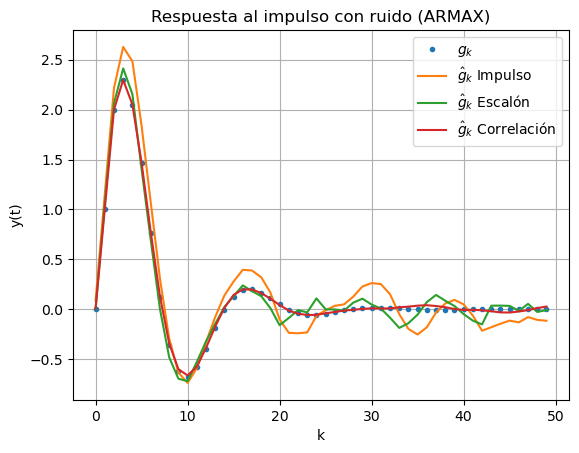

In [197]:
# Genero una señal aleatoria binaria de media 0 y varianza 1 
N = 50000
urb = np.sign(np.random.randn(N))
print(f"Media de urb={np.mean(urb)}")
print(f"Varianza de urb={np.var(urb)}")

e = 0.1*np.random.randn(N)

ruu = np.correlate(urb, urb, mode="full")/N  # correlación completa
mid = len(ruu)//2                      # índice de lag=0
M = 50
lags = np.arange(-M//2,M//2+1)

y_u = signal.lfilter(B, A, urb)
y_e = signal.lfilter(C, 1, e)
y = y_u + y_e

ryu = np.correlate(y, urb, mode="full")/N  # correlación completa
g_hat_corr = ryu[mid+np.arange(0,M)]

plt.plot(lags,ruu[mid+lags] )
plt.plot(lags,ryu[mid+lags])
plt.xlabel('Lag')
plt.ylabel('R')
plt.grid()
plt.show()


# Graficar
plt.plot(g,'.', label='$g_k$')
plt.plot(g_hat, label='$\\hat{{g}}_k$ Impulso')
plt.plot(g_hat_e, label='$\\hat{{g}}_k$ Escalón')
plt.plot(g_hat_corr,label='$\\hat{{g}}_k$ Correlación')
plt.xlabel("k")
plt.ylabel("y(t)")
plt.legend()
plt.title("Respuesta al impulso con ruido (ARMAX)")
plt.grid()
plt.show()



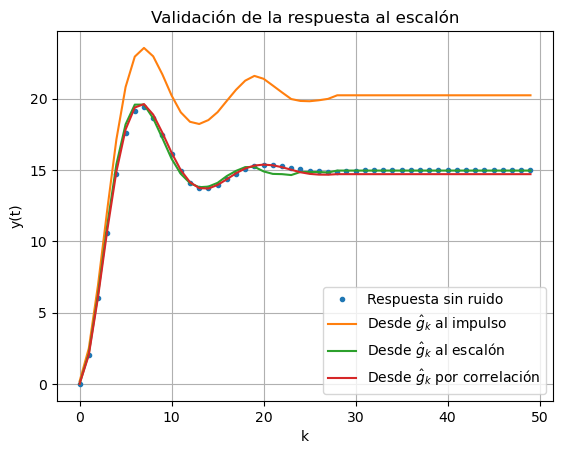

In [196]:
N_filtro = 30
ycorr_hat = signal.lfilter(g_hat_corr[0:N_filtro-1],[1],ue)

plt.plot(y_ue,'.',label='Respuesta sin ruido')
plt.plot(ye_hat,label='Desde $\\hat{{g}}_k$ al impulso')
plt.plot(yee_hat,label='Desde $\\hat{{g}}_k$ al escalón')
plt.plot(ycorr_hat,label='Desde $\\hat{{g}}_k$ por correlación')
plt.title("Validación de la respuesta al escalón")
plt.xlabel("k")
plt.ylabel("y(t)")
plt.grid()
plt.legend()
